# Objectives of this Lab
- understand cross validation

## Reminders
- activate your hsi25_ml-ssc_25.0 conda env (kernel)

# Cross validation
### General approach: 
- split our data into a test set and a not test set
- split our not test set into a training set and a validation set
- make some decisions regarding our features or model
- fit a model to the training set
- evaluate its generalizability on the validation set

### KFold
- repeat this process K times
- each point in our "not test" data appears in the validation set 1 time and the training set K-1 times
- becomes leave-one-out CV when K = # of samples in training data

### StratifiedKFold
- for classification, imagine we have N examples that are class -1 and M examples that are class +1 in our training set
- we will do KFold CV but make sure that each time we split into (smaller training, validation) the ratio of class +1 to class -1 is similar in the validation set and the training set
- this can help when we have minority classes involved

# Remember

## Cross validation is done on the **training ("not test") set**
- you should have already reserved a separate, fully excluded test set
- the main goal of CV is to allow you to make informed modeling decisions w/o wasting your test set

## Validation should mimic testing
- you are using validation to simulate a test (ie evaluating model performance on data not used for training)
- this has lots of implications, some of which we will explore in this module
- main thing to remember --> if you are doing something to the validation set, you should think if you could also do that to a completely new data (ie one you collect after training your model)

## Import the modules we'll use today
- note: `sklearn.model_selection.[KFold, StratifiedKFold, GridSearchCV]`

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import os

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from scipy import stats

plt.style.use('../files/plot_style.mplstyle')

## Back to the perovskites work
- [here](https://www.science.org/doi/full/10.1126/sciadv.aav0693) is a link to the paper we are discussing
- recall that the problem of interest was to predict whether a given material with the chemical formula, ABX3, crystallizes into perovskite or nonperovskite structures

Load the data and rename a few columns for simplicity

In [2]:
data_file = os.path.join('..', 'data', 'perovskite_data.csv')
df = pd.read_csv(data_file)
col_names = {'rA (Ang)' : 'rA',
             'rB (Ang)' : 'rB',
             'rX (Ang)' : 'rX'}
df = df.rename(columns=col_names)
df.head()

,ABX3,exp_label,is_train,A,B,X,nA,nB,nX,rA,rB,rX,t,tau,t_pred,tau_pred,tau_prob
0,AgBrO3,-1.0,1,Ag,Br,O,1,5,-2,1.28,0.31,1.40,1.11,6.43,-1,-1,0.05
1,AgCdBr3,-1.0,1,Ag,Cd,Br,1,2,-1,1.28,0.95,1.96,0.79,5.58,-1,-1,0.12
2,PbAgBr3,-1.0,1,Pb,Ag,Br,2,1,-1,1.49,1.15,1.96,0.78,7.71,-1,-1,0.01
3,AgCaCl3,-1.0,1,Ag,Ca,Cl,1,2,-1,1.28,1.00,1.81,0.78,6.00,-1,-1,0.07
4,AgClO3,-1.0,1,Ag,Cl,O,1,5,-2,1.28,0.12,1.40,1.25,15.17,-1,-1,0.00


## Consider 4 features
- each ion's oxidation state
- Goldschmidt's tolerance factor

In [3]:
target = 'exp_label'
features = ['nA', 'nB', 'nX',
            't']

X = df[features].values
y = df[target].values

# Let's save 25% for testing

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)


# Training a Decision Tree w/o validation

In [5]:
model = DecisionTreeClassifier()

# define how we're going to score our model
def get_accuracy(actual, pred):
    return len([i for i in range(len(actual)) if actual[i] == pred[i]])/len(actual)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Train acc = %.3f' % get_accuracy(y_train, y_train_pred))
print('Test acc = %.3f' % get_accuracy(y_test, y_test_pred))

Train acc = 0.882
Test acc = 0.722


## First, let's inspect the learned decision tree

Text(0.3110613810741688, 0.90625, 'x[3] <= 0.865\ngini = 0.48\nsamples = 280\nvalue = [168, 112]')

/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


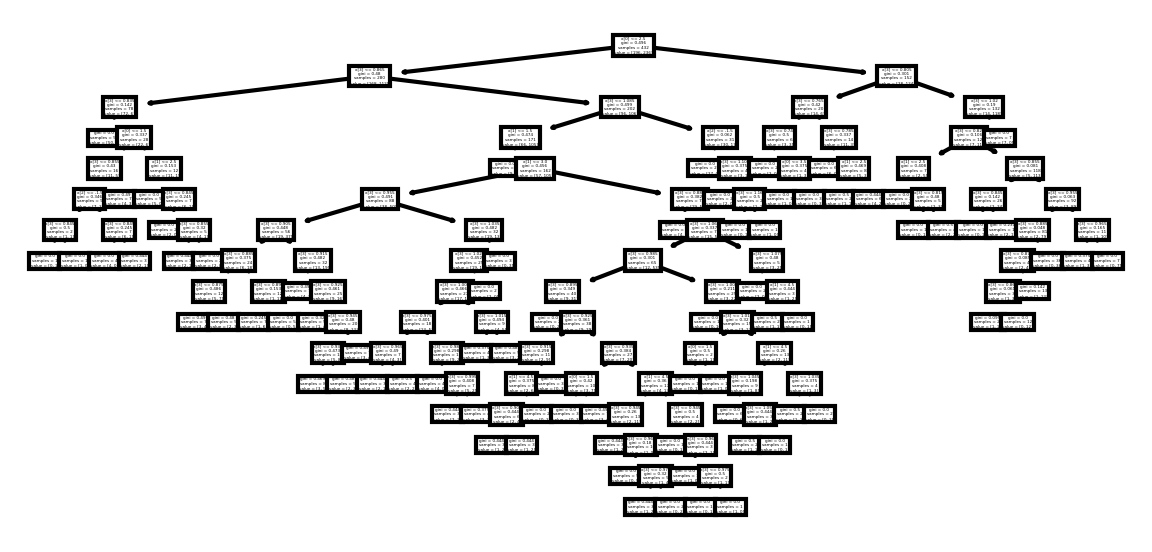

In [6]:
plot_tree(model)[1]

## So complicated! Why?

In [ ]:
help(DecisionTreeClassifier)

Train acc = 0.718
Test acc = 0.694


Text(0.25, 0.5, 'x[3] <= 0.865\ngini = 0.48\nsamples = 280\nvalue = [168, 112]')

/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


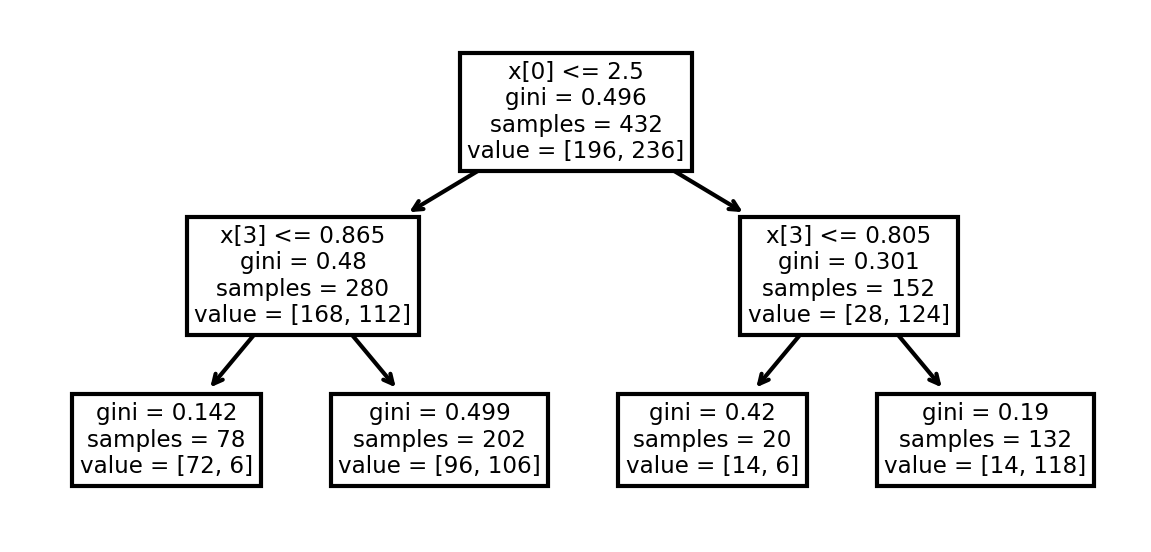

In [7]:
model = DecisionTreeClassifier(max_depth=2)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Train acc = %.3f' % get_accuracy(y_train, y_train_pred))
print('Test acc = %.3f' % get_accuracy(y_test, y_test_pred))

plot_tree(model)[1]

## `max_depth` is a **hyperparameter** that should be tuned during cross-validation

# Now let's see how KFold CV compares
- first, we'll just iterate through our enumerated *folds* to see what this is doing

In [8]:
n_folds = 5
folds = KFold(n_splits=n_folds).split(X_train, y_train)

# enumerate is a generator similar to range
for k, (train, val) in enumerate(folds):
    print('\n')
    print(k)
    print(train.shape)
    print(val.shape)
    print(val)



0
(345,)
(87,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]


1
(345,)
(87,)
[ 87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173]


2
(346,)
(86,)
[174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 

In [9]:
tmp = ['a', 'b', 'c', 'd']

for i, v in enumerate(tmp):
    print(i)
    print(v)
    print('\n')

0
a


1
b


2
c


3
d




In [10]:
for v in tmp:
    print(v)

a
b
c
d


## Now, we'll do stuff to each fold
- get our X and y for the training and validation sets (for that fold)
- fit our decision tree
- make predictions on the training and validation set
- score these predictions
- store the results                            

In [11]:
folds = KFold(n_splits=n_folds).split(X_train, y_train)

train_scores, val_scores = [], []
for k, (train, val) in enumerate(folds):

    # get our training data for this fold
    X_train_cv = X_train[train]
    y_train_cv = y_train[train]

    # get our validation data for this fold
    X_val_cv = X_train[val]
    y_val_cv = y_train[val]

    # fit to the training data
    model = DecisionTreeClassifier(max_depth=2)
    model.fit(X_train_cv, y_train_cv)

    # make predictions on training and validation data
    y_train_cv_pred = model.predict(X_train_cv)
    y_val_cv_pred = model.predict(X_val_cv)

    # score training and validation performance
    train_acc = get_accuracy(y_train_cv, y_train_cv_pred)
    val_acc = get_accuracy(y_val_cv, y_val_cv_pred)
    
    print('\nFold %i' % k)
    print('Train acc = %.3f' % train_acc)
    print('Val acc = %.3f' % val_acc)

    # store results
    train_scores.append(train_acc)
    val_scores.append(val_acc)

print('\n%i Folds' % n_folds)
print('Mean training accuracy = %.3f +/- %.4f' % (np.mean(train_scores), np.std(train_scores)))
print('Mean validation accuracy = %.3f +/- %.4f' % (np.mean(val_scores), np.std(val_scores)))


Fold 0
Train acc = 0.713
Val acc = 0.655

Fold 1
Train acc = 0.736
Val acc = 0.701

Fold 2
Train acc = 0.725
Val acc = 0.651

Fold 3
Train acc = 0.743
Val acc = 0.721

Fold 4
Train acc = 0.717
Val acc = 0.605

5 Folds
Mean training accuracy = 0.727 +/- 0.0113
Mean validation accuracy = 0.667 +/- 0.0409


# Let's write a function to carry out CV

In [12]:
def run_cv(n_folds, model, X_train, y_train, stratify=False):
    """
    Args:
        n_folds (int) : how many folds of CV to do
        model (sklearn Model) : what model do we want to fit
        X_train (np.array) : feature matrix
        y_train (np.array) : target array
        stratify (bool) : if True, use stratified CV, otherwise, use random CV
        
    Returns:
        a dictionary with scores from each fold for training and validation
            {'train' : [list of training scores],
             'val' : [list of validation scores]}
            - the length of each list = n_folds
    """
    if stratify:
        folds = StratifiedKFold(n_splits=n_folds).split(X_train, y_train)
    else:
        folds = KFold(n_splits=n_folds).split(X_train, y_train)

    train_scores, val_scores = [], []
    for k, (train, val) in enumerate(folds):

        X_train_cv = X_train[train]
        y_train_cv = y_train[train]

        X_val_cv = X_train[val]
        y_val_cv = y_train[val]

        model.fit(X_train_cv, y_train_cv)

        y_train_cv_pred = model.predict(X_train_cv)
        y_val_cv_pred = model.predict(X_val_cv)

        train_acc = get_accuracy(y_train_cv, y_train_cv_pred)
        val_acc = get_accuracy(y_val_cv, y_val_cv_pred)
        
        #print('\nFold %i' % k)
        #print('Train acc = %.3f' % train_acc)
        #print('Val acc = %.3f' % val_acc)

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    print('\n%i Folds' % n_folds)
    print('Mean training accuracy = %.3f +/- %.4f' % (np.mean(train_scores), np.std(train_scores)))
    print('Mean validation accuracy = %.3f +/- %.4f' % (np.mean(val_scores), np.std(val_scores)))
    
    return {'train' : train_scores,
            'val' : val_scores}

In [ ]:
help(StratifiedKFold)

## Let's look at the effect of folds on score distributions
- we'll run KFold CV on a Decision Tree with max_depth=5 and K ranging from 2 to 432

In [13]:
max_depth = 5
model = DecisionTreeClassifier(max_depth=max_depth)

number_of_folds = [2, 5, 10, 100, 432]
scores = [run_cv(model=model, 
                   n_folds=n, 
                   X_train=X_train, 
                   y_train=y_train,
                   stratify=False) for n in number_of_folds]
train_scores = [score['train'] for score in scores]
val_scores = [score['val'] for score in scores]


2 Folds
Mean training accuracy = 0.831 +/- 0.0116
Mean validation accuracy = 0.785 +/- 0.0116

5 Folds
Mean training accuracy = 0.836 +/- 0.0097
Mean validation accuracy = 0.755 +/- 0.0415

10 Folds
Mean training accuracy = 0.832 +/- 0.0051
Mean validation accuracy = 0.787 +/- 0.0515

100 Folds
Mean training accuracy = 0.829 +/- 0.0020
Mean validation accuracy = 0.802 +/- 0.2074

432 Folds
Mean training accuracy = 0.829 +/- 0.0009
Mean validation accuracy = 0.801 +/- 0.3993


## How do the distributions of training and test scores vary with number of folds?
- let's write a function to plot these results

In [14]:
def hist_with_kde(data, 
                  label,
                 show_xlabel=True,
                 show_xticks=True):
    """
    returns matplotlib axis object of KDE w/ histogram
    
    Args:
        data (1d np.array): data to generate a histogram for
        label (str) : what to label that data
        show_xlabel (bool) : if True, make an xlabel
        show_xticks (bool) : if True, show xticks
    """

    # get range of colors
    cmap = matplotlib.cm.get_cmap('magma')
    colors = [cmap(i/5) for i in range(5)]
    #colors = ['blue', 'orange', 'purple', 'green', 'turquoise', 'black', 'pink']

    # set plotting parameters
    alpha = 0.1
    width = 0.01
    n_bins = 100
    # plot our histogram
    ax = plt.hist(data, density=True, alpha=alpha, bins=n_bins, width=width, color=colors[i])

    # fit a kernel density estimate to our discrete histogram
    kde = stats.gaussian_kde(data)

    # determine independent variables on which we'd like to see our kde
    fake_x = np.linspace(0, 1.01, 100)

    # determine the value of the kde fit to our histogram at each x and normalize
    y = kde(fake_x)
    y = y/max(y)

    # plot kde
    ax = plt.plot(fake_x, y, '-', color=colors[i], label=label)
    
    if show_xlabel:
        ax = plt.xlabel('accuracy')
    if not show_xticks:
        ax = plt.gca().xaxis.set_ticklabels([])
    ax = plt.ylabel('norm. counts')
    return ax

## Now, we'll see how the training accuracy and validation accuracy evolve as we change the number of folds

/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


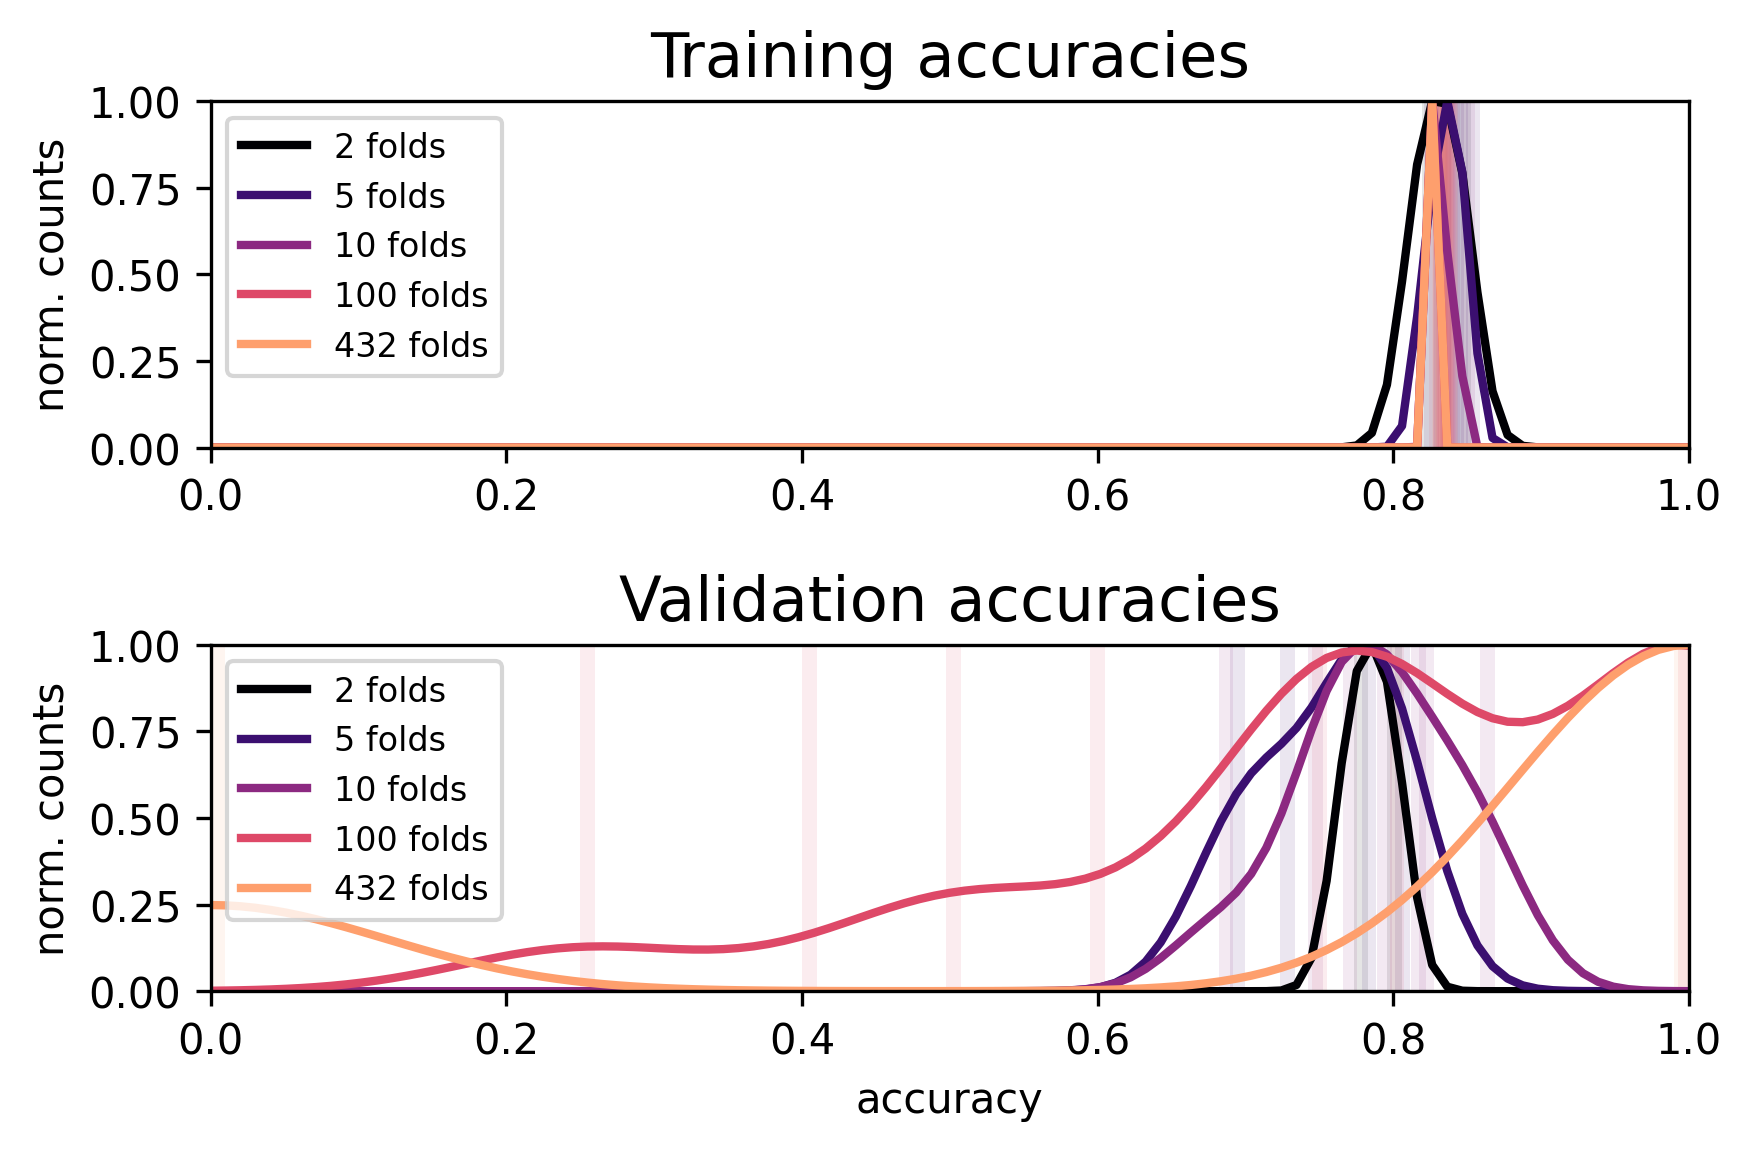

In [15]:
fig = plt.figure(figsize=(6,4))

xlim = (0,1)
ylim = xlim

# set how many folds we want to plot (1 = [2], 2 = [2, 5], 3 = ...)
folds_to_plot = 5

# generate a histogram of our training performances
ax1 = plt.subplot(211)
for i in range(len(number_of_folds)):
    if i > folds_to_plot-1:
        continue
    z = train_scores[i]
    label = '%i folds' % number_of_folds[i]
    ax1 = hist_with_kde(z, label, show_xticks=True, show_xlabel=False)

ax1 = plt.xlim(xlim)
ax1 = plt.ylim(ylim)
ax1 = plt.title('Training accuracies')
ax1 = plt.legend()

# generate a histogram of our validation performances
ax2 = plt.subplot(212)
for i in range(len(number_of_folds)):
    if i > folds_to_plot-1:
        continue    
    z = val_scores[i]
    label = '%i folds' % number_of_folds[i]
    ax2 = hist_with_kde(z, label)

ax2 = plt.xlim(xlim)
ax2 = plt.ylim(ylim)
ax2 = plt.title('Validation accuracies')
ax2 = plt.legend()

## How many folds to use?
- increasing the # of folds:
    - training data gets more similar between folds
    - validation data gets *much* less similar between folds
    - CV takes longer
- one perspective:
    - use high *k* to get robust estimation of generalization performance
        - you get many *simulated tests*
    - use low *k* to save computational time
        - what if you have 460,000,000 data points instead of 460?
        - what if you want to explore many hyperparameters and combinations?

# Group activity
**Guidelines**:
- Use `run_cv` to optimize the `max_depth` hyperparameter in your decision tree
- Try at least 10 values
- Use stratified cross-validation
- Plot the training accuracy and the validation accuracy as a function of `max_depth`

In [ ]:
######## students do this #########


5 Folds
Mean training accuracy = 0.678 +/- 0.0103
Mean validation accuracy = 0.641 +/- 0.0179

5 Folds
Mean training accuracy = 0.718 +/- 0.0164
Mean validation accuracy = 0.685 +/- 0.0341

5 Folds
Mean training accuracy = 0.782 +/- 0.0219
Mean validation accuracy = 0.762 +/- 0.0351

5 Folds
Mean training accuracy = 0.815 +/- 0.0190
Mean validation accuracy = 0.787 +/- 0.0437

5 Folds
Mean training accuracy = 0.826 +/- 0.0092
Mean validation accuracy = 0.773 +/- 0.0494

5 Folds
Mean training accuracy = 0.851 +/- 0.0087
Mean validation accuracy = 0.778 +/- 0.0382

5 Folds
Mean training accuracy = 0.860 +/- 0.0102
Mean validation accuracy = 0.780 +/- 0.0471

5 Folds
Mean training accuracy = 0.866 +/- 0.0096
Mean validation accuracy = 0.776 +/- 0.0513

5 Folds
Mean training accuracy = 0.876 +/- 0.0097
Mean validation accuracy = 0.785 +/- 0.0597

5 Folds
Mean training accuracy = 0.878 +/- 0.0105
Mean validation accuracy = 0.773 +/- 0.0588

5 Folds
Mean training accuracy = 0.883 +/- 0.0087

/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


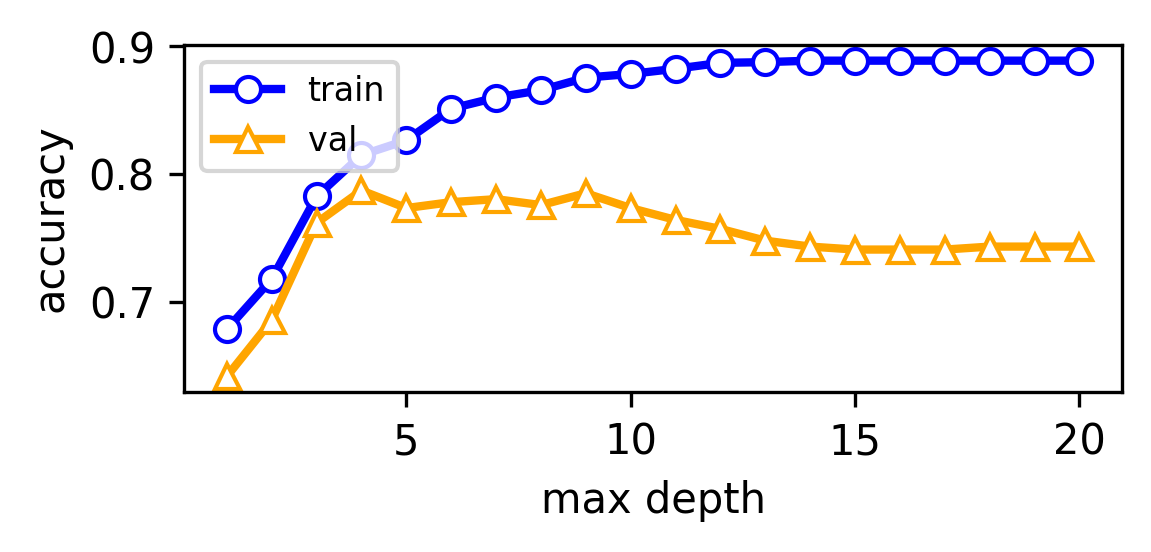

In [16]:
max_depths = list(range(1, 21))
n_folds = 5

train_means = []
val_means = []
for max_depth in max_depths:
    #print('\nMax depth = %s' % str(max_depth))
    
    model = DecisionTreeClassifier(max_depth=max_depth)
    data = run_cv(model=model,
                  n_folds=n_folds,
                  X_train=X_train,
                  y_train=y_train,
                    stratify=True)
    
    mean_train = np.mean(data['train'])
    mean_val = np.mean(data['val'])
    
    train_means.append(mean_train)
    val_means.append(mean_val)

fig = plt.figure(figsize=(4,2))
ax = plt.subplot()

ax = plt.plot(max_depths, train_means, markerfacecolor='white', color='blue', marker='o', label='train')
ax = plt.plot(max_depths, val_means, markerfacecolor='white', color='orange', marker='^', label='val')
ax = plt.legend(loc='upper left')
ax = plt.xlabel('max depth')
ax = plt.ylabel('accuracy')

# A more streamlined way to do this with `GridSearchCV`

In [ ]:
help(GridSearchCV)

In [17]:
estimator = DecisionTreeClassifier()
param_grid = {'max_depth' : list(range(1,21))}
scoring = 'accuracy'
cv = 5

gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, cv=cv)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [18]:
gs.best_params_

{'max_depth': 4}

In [19]:
gs.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [20]:
gs.best_estimator_.predict(X_train)


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,
        1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,
        1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,
        1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,
       -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1

In [21]:
gs.cv_results_

{'mean_fit_time': array([0.00076962, 0.0005898 , 0.00066428, 0.00065494, 0.0005311 ,
        0.00054131, 0.00050297, 0.00052433, 0.00047674, 0.00045176,
        0.00043139, 0.00044899, 0.0003932 , 0.00037141, 0.00035157,
        0.00035281, 0.00033317, 0.0003181 , 0.00030866, 0.00030441]),
 'std_fit_time': array([2.27071988e-04, 5.13074123e-05, 2.69414066e-04, 2.27189113e-04,
        1.46054731e-04, 1.32918954e-04, 4.79510917e-05, 4.06144912e-05,
        6.30002768e-06, 2.70835111e-05, 9.06567641e-06, 4.13127597e-05,
        1.41472048e-05, 8.53977943e-06, 5.65931585e-06, 7.57766112e-06,
        1.81132857e-05, 6.71545194e-06, 5.55796613e-06, 1.00864304e-05]),
 'mean_score_time': array([0.00060716, 0.00046778, 0.00042281, 0.00032101, 0.00026803,
        0.00043588, 0.0002656 , 0.00029407, 0.00025067, 0.00023041,
        0.00021844, 0.00021858, 0.00019517, 0.00018263, 0.00017514,
        0.00017262, 0.00016379, 0.00015612, 0.00015235, 0.00014734]),
 'std_score_time': array([1.86315271e-